In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.integrate as ode 

Evaluate range of ping pong ball as function elevation, temperature.
Take into account drag and Magnus effect and air density vs P and T.

In [3]:
# ODE for ball through air, with drag and lift (Magnus effect)
# useful reference: 
# Cross, R., Lindsey, C. Measurements of drag and lift on tennis balls in flight. 
# Sports Eng 17, 89–96 (2014). https://doi.org/10.1007/s12283-013-0144-9

def trajectory_no_drag(Y,t,g = 9.81):

    x,y,vx,vy = Y

    dydt = [
        vx,
        vy,
        0,
        -g
    ]
    return dydt

def trajectory_drag(Y,t,C, mass, g = 9.81):
    x, y, vx, vy = Y 

    v = np.sqrt(vx**2.+vy**2.)

    dydt = [
        vx, 
        vy,
        -C/mass*v*vx,
        -C/mass*v*vy - g
    ]
    return dydt

def trajectory_drag_lift(Y,t,C_drag,C_lift,mass, g = 9.81):

    x, y, vx, vy = Y 

    v = np.sqrt(vx**2.+vy**2.)

    dydt = [
        vx, 
        vy,
        -C_drag/mass*v*vx - C_lift/mass*v*vy,
        -C_drag/mass*v*vy + C_lift/mass*v*vx - g
    ]
    return dydt


    

In [4]:
def C_drag_sphere(rho = 1.3, Cd = 0.47, diameter = 40):
    """
    rho: air density [kg/m3]
    Cd: drag coefficient of sphere
    diameter: diameter of sphere [mm]
    """
    radius = diameter / 2. * 1e-3 # [m]
    A = np.pi * radius**2.
    return 0.5 * rho * Cd * A 

def C_lift_sphere(rho = 1.3, omega = 60, diameter = 40):
    """
    rho: air density [kg/m3]
    omega: angular velocity [rps]
    diameter: diameter of sphere [mm]
    """
    radius = diameter/2. * 1.e-3 # [m]
    A = np.pi * radius**2.
    # empirical function that relates angular velocity to Magnus coefficient 
    # reference: 
    # Front. Appl. Math. Stat., 28 January 2019
    # Sec. Mathematics of Computation and Data Science
    # Volume 4 - 2018 | https://doi.org/10.3389/fams.2018.00066
    omega_rad = omega * 2.*np.pi # [rad/s]
    Cmagnus = 0.319 * (1.-np.exp(-2.48e-3 * omega_rad))
    
    return 0.5 * rho * Cmagnus * A

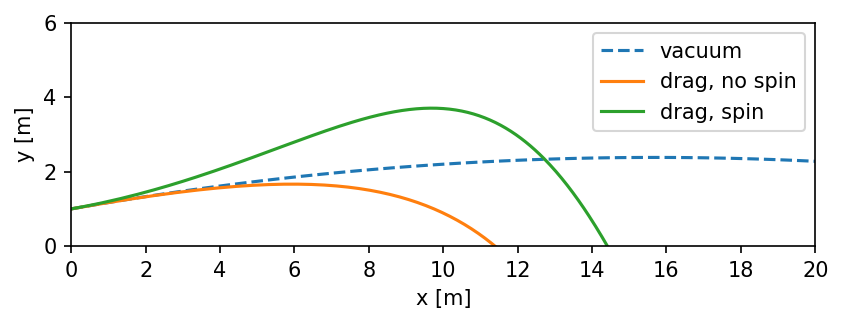

In [36]:
# Plot ball through the air, with drag and spin.

v0 = 30 # [m/s]
angle = 10*np.pi/180 # [rad]

mass = 2.7e-3 # [kg], ping pong ball
#mass = 0.145 # [kg], baseball

C_drag = C_drag_sphere()
C_lift = C_lift_sphere()

y0 = [
    0, # initial x 
    1., # initial y
    v0*np.cos(angle), # initial vx 
    v0*np.sin(angle) # initial vy 
]



t = np.linspace(0,10,1001)



solution = ode.odeint(trajectory_no_drag, y0, t)

xval = solution[:,0]
yval = solution[:,1]
vxval = solution[:,2]
vyval = solution[:,3]

solution_drag = ode.odeint(trajectory_drag, y0, t, args=(C_drag,mass))

xval_drag = solution_drag[:,0]
yval_drag = solution_drag[:,1]
vxval_drag = solution_drag[:,2]
vyval_drag = solution_drag[:,3]

solution_magnus = ode.odeint(trajectory_drag_lift, y0, t, args = (C_drag, C_lift, mass))

xval_magnus = solution_magnus[:,0]
yval_magnus = solution_magnus[:,1]
vxval_magnus = solution_magnus[:,2]
vyval_magnus = solution_magnus[:,3]


# fig, ax = plt.subplots(dpi=150)
# ax.plot(t,xval_drag, 'b', label='x(t)')
# ax.plot(t,yval_drag, 'r', label='y(t)')
# ax2 = ax.twinx()
# ax2.plot(t,vxval_drag, 'b--', label='vx(t)')
# ax2.plot(t,vyval_drag, 'r--', label='vy(t)')
# ax.set_xlabel('t [s]')
# ax.legend(loc='center left')
# ax2.legend(loc='center right')
# ax.set_ylim(0,)

fig, ax = plt.subplots(dpi=150)
ax.set_aspect('equal')
ax.plot(xval, yval,'--', label='vacuum')
ax.plot(xval_drag, yval_drag, label='drag, no spin')
ax.plot(xval_magnus, yval_magnus, label='drag, spin')
ax.set_ylim(0,6)
ax.set_xlim(0,20)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.legend()

In [16]:
# scan through parameters to find optimal angle 

def eval_trajectory(func, v0, angle, C_drag, C_lift, mass, height = 1.0, g = 9.81):
    
    angle_rad = angle*np.pi/180 # convert deg to rad

    y0 = [
        0, # initial x 
        height, # initial y
        v0*np.cos(angle_rad), # initial vx 
        v0*np.sin(angle_rad), # initial vy 
    ]

    t = np.linspace(0,10,5001)

    solution = ode.odeint(func, y0, t, args=(C_drag, C_lift,mass,g))

    x = solution[:,0]
    y = solution[:,1]
    vx = solution[:,2]
    vy = solution[:,3]

    return x, y, vx, vy

def eval_range(x,y):
    # evaluate range, given x and y data. 
    # find point in x when y returns to 0 
    # skip first 10 samples to ensure we don't just find the starting point 
    #return_to_zero = np.argmin(np.abs(y)[10:]) + 10
    return_to_zero = np.argmax(y<0)
    return x[return_to_zero]

def eval_optimum_angle(func, v0, C_drag, C_lift, mass):
    
    angles = np.linspace(0.01,60,500)

    ranges = np.zeros_like(angles)
    for i, _angle in enumerate(angles):

        x,y,vx,vy = eval_trajectory(func, v0, _angle, C_drag, C_lift, mass)

        range = eval_range(x,y)

        #print(f"{angle:0.2f} {range:0.2f}")
        ranges[i] = range 

    max_range_idx = np.argmax(ranges)
    optimum_angle = angles[max_range_idx]

    # evaluate range at optimum angle 
    x,y,vx,vy = eval_trajectory(func, v0, optimum_angle, C_drag, C_lift, mass)
    optimum_range = eval_range(x,y)

    return optimum_angle, optimum_range



Optimum angle: 11.43 [deg]
Range at optimum: 14.42 [m]


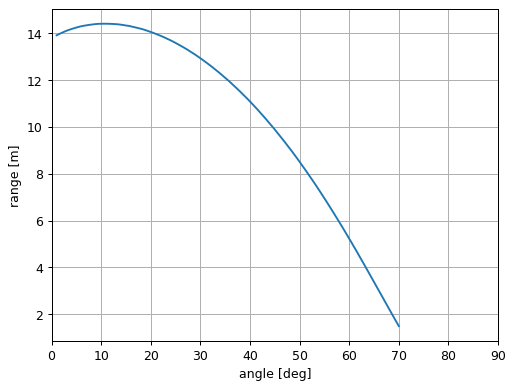

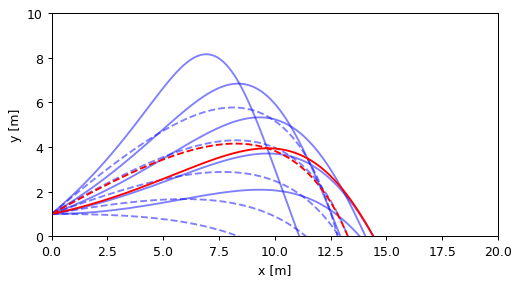

In [32]:
# Plot all of the trajectories for a set of angles 

v0 = 30 
angles = np.linspace(1,70,100)

ranges = np.zeros_like(angles)
for i, angle in enumerate(angles):

    x,y,vx,vy = eval_trajectory(trajectory_drag_lift, v0, angle, C_drag, C_lift, mass)
    range = x[np.argmin(np.abs(y)[10:])+10]
    #print(f"{angle:0.2f} {range:0.2f}")
    ranges[i] = range 

fig, ax = plt.subplots(dpi=90)
ax.plot(angles, ranges)
ax.set_xlim(0,90)
ax.grid()
ax.set_xlabel('angle [deg]')
ax.set_ylabel('range [m]')


fig, ax = plt.subplots(dpi=90)
ax.set_aspect('equal')
ax.set_xlim(0,20)
ax.set_ylim(0,10)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
for i, angle in enumerate(np.arange(0,50,10)):
    x,y,vx,vy = eval_trajectory(trajectory_drag_lift, v0, angle, C_drag, 0, mass)
    ax.plot(x,y,'--', color='b', alpha=0.5)

    x,y,vx,vy = eval_trajectory(trajectory_drag_lift, v0, angle, C_drag, C_lift, mass)
    ax.plot(x, y, 'b', alpha=0.5)

# plot optimal angle, no lift
optimum_angle_nolift, range = eval_optimum_angle(trajectory_drag_lift, v0, C_drag, 0, mass)
x,y,vx,vy = eval_trajectory(trajectory_drag_lift, v0, optimum_angle_nolift, C_drag, 0, mass)
ax.plot(x,y,'r--')

# plot optimal angle, with lift
optimum_angle, range = eval_optimum_angle(trajectory_drag_lift, v0, C_drag, C_lift, mass)
x,y,vx,vy = eval_trajectory(trajectory_drag_lift, v0, optimum_angle, C_drag, C_lift, mass)
ax.plot(x,y,'r')

print(f"Optimum angle: {optimum_angle:0.2f} [deg]")
print(f"Range at optimum: {range:0.2f} [m]")



In [24]:
# Scan through parameters.
# Find optimum angle, range as function of:
# - initial velocity between [10,100]
# - initial angular velocity between [50,100] rps 
# - air density ( find reasonable ranges as function of elevation and temperature )
# - 40 vs 40+ ball (mass and radius)

spin = 30
print(f"scan over initial velocities.")
print(f"spin: {spin:0.2f} [rps]")
print(f"v0[m/s] angle[deg] range[m]")
velocities = np.arange(10,100,10)
for v0 in velocities:
    _C_lift = C_lift_sphere(omega=spin)
    optimum_angle, range = eval_optimum_angle(trajectory_drag_lift, v0, C_drag, C_lift, mass)
    print(f"{v0} {optimum_angle:0.2f} {range:0.2f}")


v0 = 40
print(f"\nscan over spin.")
print(f"v0: {v0:0.2f} [m/s]")
print(f"spin[rps] angle[deg] range[m]")
spins = np.arange(10,100,10)
for spin in spins:
    _C_lift = C_lift_sphere(omega=spin)
    optimum_angle, range = eval_optimum_angle(trajectory_drag_lift, v0, C_drag, _C_lift, mass)
    print(f"{spin} {optimum_angle:0.2f} {range:0.2f}")

print(f"\n40 vs 40+ ball")
v0 = 40
spin = 30
print(f"v0: {v0:0.2f} [m/s]")
print(f"spin: {spin:0.2f} [rps]")
print(f"d[mm] angle[deg] range[m]")
diameters = [ 39.6, 40.0, 40.4 ]
for diameter in diameters:
    _C_drag = C_drag_sphere(diameter=diameter)
    _C_lift = C_lift_sphere(diameter=diameter)
    optimum_angle, range = eval_optimum_angle(trajectory_drag_lift, v0, _C_drag, _C_lift, mass)
    print(f"{diameter} {optimum_angle:0.2f} {range:0.2f}")

print(f"\nScan over air density")
v0 = 40
spin = 30
print(f"v0: {v0:0.2f} [m/s]")
print(f"spin: {spin:0.2f} [rps]")
print(f"rho[kg/m3] angle[deg] range[m]")
densities = [ 1.0, 1.1, 1.2, 1.3, 1.4 ]
for rho in densities:
    _C_drag = C_drag_sphere(rho=rho)
    _C_lift = C_lift_sphere(rho=rho)
    optimum_angle, range = eval_optimum_angle(trajectory_drag_lift, v0, _C_drag, _C_lift, mass)
    print(f"{rho} {optimum_angle:0.2f} {range:0.2f}")


scan over initial velocities.
spin: 30.00 [rps]
v0[m/s] angle[deg] range[m]
10 27.66 6.35
20 18.28 11.34
30 11.43 14.42
40 5.66 16.56
50 1.69 18.18
60 0.25 19.45
70 0.01 20.44
80 0.01 21.20
90 0.01 21.82

scan over spin.
v0: 40.00 [m/s]
spin[rps] angle[deg] range[m]
10 22.73 15.75
20 18.28 16.04
30 14.32 16.24
40 11.31 16.39
50 7.94 16.49
60 5.66 16.56
70 3.62 16.61
80 1.81 16.64
90 0.37 16.66

40 vs 40+ ball
v0: 40.00 [m/s]
spin: 30.00 [rps]
d[mm] angle[deg] range[m]
39.6 5.90 16.81
40.0 5.66 16.56
40.4 5.66 16.32

Scan over air density
v0: 40.00 [m/s]
spin: 30.00 [rps]
rho[kg/m3] angle[deg] range[m]
1.0 8.55 20.11
1.1 7.46 18.75
1.2 6.38 17.58
1.3 5.66 16.56
1.4 5.06 15.67


In [21]:
# Air density vs. altitude. 
# From https://www.grc.nasa.gov/www/k-12/airplane/atmosmet.html

def temp_vs_altitude(altitude):
    """
    altitude: [m]

    return: temp [C]
    """
    return 15.04 - 0.00649*altitude

def pressure_vs_temp(temp):
    """
    temp: [C]

    return: pressure [kPa]
    """
    return 101.29 * ((temp + 273.1)/288.08)**5.256

def density_vs_p_T(pressure, temp):
    """
    pressure: [kPa]
    temp: [C]

    return: density [kg/m3]
    """
    return pressure / 0.2869 / (temp + 273.1)

def density_vs_altitude(altitude):
    """
    altitude: [m]
    return: density [kg/m3], avg temp [C]
    """
    temp = temp_vs_altitude(altitude)
    p = pressure_vs_temp(temp)
    rho = density_vs_p_T(p,temp)
    return rho, temp

def density_vs_altitude_temp(altitude, temp):
    """ 
    air density as a function of altitude and temperature 
    altitude is from model (NASA). then temp correction from ideal gas e.o.s.
    altitude: [m]
    temp: [C]

    return: density [kg/m3]
    """ 
    outside_rho, outside_temp = density_vs_altitude(altitude)
    rho = outside_rho * ( outside_temp + 273.1 ) / ( temp + 273.1 )
    return rho 



[1.20585635 1.14983838 1.09594648 1.04411837 0.99429303 0.94641071
 0.90041291 0.85624234 0.81384295 0.77315989 0.7341395 ]
Evaluating 20 C
0.0 1.21 17.92 15.34
400.0 1.15 18.52 15.86
800.0 1.10 18.52 16.39
1200.0 1.04 19.25 16.95
1600.0 0.99 19.49 17.53
2000.0 0.95 19.61 18.13
2400.0 0.90 20.33 18.76
2800.0 0.86 21.17 19.40
3200.0 0.81 21.41 20.08
3600.0 0.77 21.53 20.78
4000.0 0.73 22.49 21.50
Evaluating 25 C
0.0 1.19 18.04 15.52
400.0 1.13 18.64 16.04
800.0 1.08 19.00 16.59
1200.0 1.03 19.37 17.15
1600.0 0.98 19.49 17.74
2000.0 0.93 19.97 18.34
2400.0 0.89 20.33 18.97
2800.0 0.84 21.17 19.63
3200.0 0.80 21.41 20.30
3600.0 0.76 21.53 21.01
4000.0 0.72 22.25 21.74
Evaluating 30 C
0.0 1.17 18.16 15.70
400.0 1.11 19.13 16.23
800.0 1.06 19.13 16.78
1200.0 1.01 19.37 17.35
1600.0 0.96 19.85 17.94
2000.0 0.92 19.97 18.55
2400.0 0.87 20.33 19.19
2800.0 0.83 21.17 19.85
3200.0 0.79 21.41 20.53
3600.0 0.75 22.13 21.24
4000.0 0.71 22.25 21.98
Evaluating 35 C
0.0 1.15 18.40 15.88
400.0 1.09 19.

Text(0.5, 0, 'Elevation [ft]')

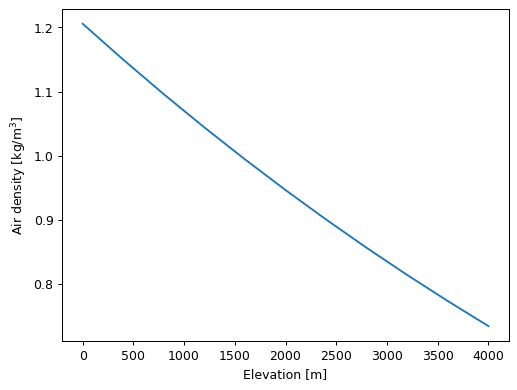

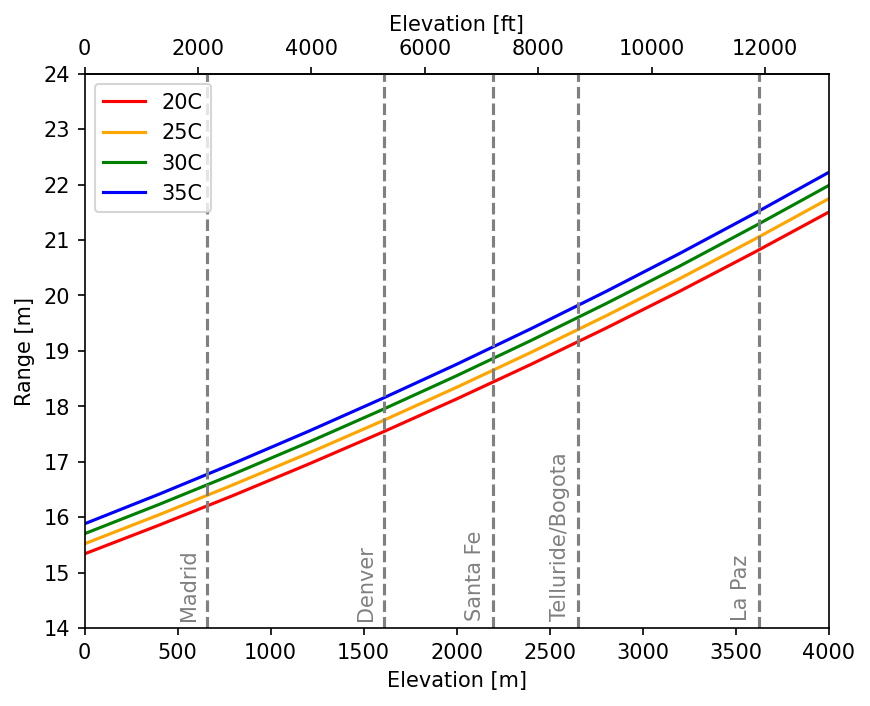

In [37]:
elevations = np.linspace(0,4000,11)
elevations_ft = elevations * 3.28

#densities, outside_temp = density_vs_altitude(elevations_m)
densities = density_vs_altitude_temp(elevations, 20.)
print(densities)
#print(elevations_m)
#print(densities, avg_temps)

fig, ax = plt.subplots(dpi=90)
ax.plot(elevations, densities)
ax.set_xlabel('Elevation [m]')
ax.set_ylabel('Air density [kg/m$^3$]')


fig, ax = plt.subplots(dpi=150)
#ax.grid('both')
temps = [20, 25, 30, 35]
v0 = 32
spin = 30
mass = 2.7e-3
colors = ['red', 'orange', 'green', 'blue']
for j, temp in enumerate(temps):
    print(f"Evaluating {temp} C")
    densities = density_vs_altitude_temp(elevations, temp)
    ranges = np.zeros_like(densities)
    for i, density in enumerate(densities):
        _C_drag = C_drag_sphere(rho=density)
        _C_lift = C_lift_sphere(rho=density, omega=spin)
        optimum_angle, range = eval_optimum_angle(trajectory_drag_lift, v0, _C_drag, _C_lift, mass)
        print(f"{elevations[i]} {density:0.2f} {optimum_angle:0.2f} {range:0.2f}")
        ranges[i] = range
    ax.plot(elevations, ranges, color=colors[j], label=f"{temp}C")
ax.set_xlabel('Elevation [m]')
ax.set_ylabel('Range [m]')
ax.set_xlim(0,4000)
ax.set_ylim(14,24)
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.legend()


cities = [ 'Madrid', 'Denver', 'Santa Fe', 'Telluride/Bogota', 'La Paz' ]
city_elevations = np.array([ 2156, 5279, 7200, 8700, 11893 ])
city_elevations_m = city_elevations / 3.28

for city, elev in zip(cities, city_elevations_m):
    ax.axvline(elev, ls='--', color='gray')
    ax.text( elev-150, 14.2, city, rotation=90., color='gray' )

def ft2m(ft):
    return ft / 3.28

def m2ft(m):
    return m * 3.28

ax2 = ax.secondary_xaxis('top', functions=(m2ft, ft2m))
ax2.set_xlabel('Elevation [ft]')